In [7]:
import csv
import os, sys, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import date
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
# display for this notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

ImportError: No module named 'sklearn.model_selection'

In [ ]:
dfoff = pd.read_csv('E:/czy/jupyter_notebook/data/o2o/ccf_offline_stage1_train.csv')

dftest = pd.read_csv('E:/czy/jupyter_notebook/data/o2o/ccf_offline_stage1_test_revised.csv')

 

dfon = pd.read_csv('E:/czy/jupyter_notebook/data/o2o/ccf_online_stage1_train.csv')

 

dfoff.head(5)

In [ ]:
import os
cwd = os.getcwd()
print(cwd)

In [ ]:
dfoff = pd.read_csv('data/ccf_offline_stage1_train.csv')

dftest = pd.read_csv('data/ccf_offline_stage1_test_revised.csv')

 

dfon = pd.read_csv('data/ccf_online_stage1_train.csv')

 

dfoff.head(5)

In [14]:
dfoff.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 7 columns):
User_id          int64
Merchant_id      int64
Coupon_id        object
Discount_rate    object
Distance         object
Date_received    object
Date             object
dtypes: int64(2), object(5)
memory usage: 93.7+ MB


In [16]:
print('有优惠券,购买商品条数',dfoff[(dfoff['Date_received']!='null')&(dfoff['Date']!='null')].shape[0])
print('无优惠券,购买商品条数',dfoff[(dfoff['Date_received']=='null')&(dfoff['Date']!='null')].shape[0])
print('有优惠券,不购买商品条数',dfoff[(dfoff['Date_received']!='null')&(dfoff['Date']=='null')].shape[0])
print('无优惠券，不购买商品条数', dfoff[(dfoff['Date_received'] == 'null') & (dfoff['Date'] == 'null')].shape[0])

有优惠券,购买商品条数 75382
无优惠券,购买商品条数 701602
有优惠券,不购买商品条数 977900
无优惠券，不购买商品条数 0


In [22]:
#在测试集中出现的用户但训练集没有出现 
print('1.User_id in training set but not in test set',set(dftest['User_id']) - set(dfoff['User_id']))
#在测试集中出现的商户但训练集没有出现
print('2. Merchant_id in training set but not in test set', set(dftest['Merchant_id']) - set(dfoff['Merchant_id']))

1.User_id in training set but not in test set {2495873, 1286474}
2. Merchant_id in training set but not in test set {5920}


Note
1.数据中大量的购物卷没有花掉(977900),其中很多人购买商品没有优惠券(701602),用优惠券购买商品的只有很少一部分人(75382).
2.detest中有两个用户是新的,没有出现在dfoff中.detest中有一个商铺是新的,没有出现在dfoff中.

# 优惠券和距离

In [23]:
print('Discount_rate类型:',dfoff['Discount_rate'].unique())
print('Distance类型:',dfoff['Distance'].unique())

Discount_rate类型: ['null' '150:20' '20:1' '200:20' '30:5' '50:10' '10:5' '100:10' '200:30'
 '20:5' '30:10' '50:5' '150:10' '100:30' '200:50' '100:50' '300:30' '50:20'
 '0.9' '10:1' '30:1' '0.95' '100:5' '5:1' '100:20' '0.8' '50:1' '200:10'
 '300:20' '100:1' '150:30' '300:50' '20:10' '0.85' '0.6' '150:50' '0.75'
 '0.5' '200:5' '0.7' '30:20' '300:10' '0.2' '50:30' '200:100' '150:5']
DIstance类型: ['0' '1' 'null' '2' '10' '4' '7' '9' '3' '5' '6' '8']


处理方式:将str变成numeric
1.将满xx减yy类型的券变成折扣率:1-yy/xx,同时建立折扣券相关的特征discount_rate,discount_man,discount_type
2.将距离str转为int

In [48]:
#convert Discount_rate and Distance
def getDiscountType(row):
    if row == 'null':
        return 'null'
    elif ':' in row:
        return 1
    else:
        return 0
    
def convertRate(row):
    '''Convert discount to rate'''
    if row == 'null':
        return 1.0
    elif ':' in row:
        rows = row.split(':')
        return 1.0 - float(rows[1])/float(rows[0])
    else:
        return float(row)
    
def getDiscountMan(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[0])
    else:
        return 0
def getDiscountJian(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[1])
    else:
        return 0
def processData(df):
    #convert discunt_rate
    df['discount_rate'] = df['Discount_rate'].apply(convertRate)
    df['discount_man'] = df['Discount_rate'].apply(getDiscountMan)
    df['discount_jian'] = df['Discount_rate'].apply(getDiscountJian)
    df['discount_type']=df['Discount_rate'].apply(getDiscountType)
    print(df['discount_rate'].unique())
    
    #convert distance
    df['distance'] = df['Distance'].replace('null',-1).astype(int)
    print(df['distance'].unique())
    return df

dfoff = processData(dfoff)
dftest = processData(dftest)

[ 1.          0.86666667  0.95        0.9         0.83333333  0.8         0.5
  0.85        0.75        0.66666667  0.93333333  0.7         0.6
  0.96666667  0.98        0.99        0.975       0.33333333  0.2         0.4       ]
[ 0  1 -1  2 10  4  7  9  3  5  6  8]
[ 0.83333333  0.9         0.96666667  0.8         0.95        0.75        0.98
  0.5         0.86666667  0.6         0.66666667  0.7         0.85
  0.33333333  0.94        0.93333333  0.975       0.99      ]
[ 1 -1  5  2  0 10  3  6  7  4  9  8]


In [49]:
dfoff.head(2)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,discount_rate,discount_man,discount_jian,sidcount_type,distance,discount_type
0,1439408,2632,null,null,0,null,20160217,1.000000,0,0,null,0,null
1,1439408,4663,11002,150:20,1,20160528,null,0.866667,150,20,1,1,1


In [45]:
dftest.head(2)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,discount_rate,discount_man,discount_jian,sidcount_type,distance,discount_type
0,4129537,450,9983,30:5,1,20160712,0.833333,30,5,1,1,1
1,6949378,1300,3429,30:5,null,20160706,0.833333,30,5,1,-1,1


In [50]:
del dfoff['sidcount_type']

In [51]:
del dftest['sidcount_type']

In [52]:
dfoff.head(2)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,discount_rate,discount_man,discount_jian,distance,discount_type
0,1439408,2632,null,null,0,null,20160217,1.000000,0,0,0,null
1,1439408,4663,11002,150:20,1,20160528,null,0.866667,150,20,1,1


# 时间

这里有两个时间,Date_received和Date,即优惠券收到日期和消费日期.

In [65]:
date_received = dfoff['Date_received'].unique()
date_received = sorted(date_received[date_received != 'null'])

date_buy = dfoff['Date'].unique()
date_buy = sorted(date_buy[date_buy != 'null'])

date_buy = sorted(dfoff[dfoff['Date'] != 'null']['Date'])
print('优惠券收到日期从',date_received[0],'到',date_received[-1])
print('消费日期从',date_buy[0],'到',date_buy[-1])

优惠券收到日期从 20160101 到 20160615
消费日期从 20160101 到 20160630


看一下每天的顾客收到coupon的数目,以及受到coupon后用coupon的数目

In [106]:
couponbydate = dfoff[dfoff['Date_received'] != 'null'][['Date_received', 'Date']].groupby(['Date_received'], as_index=False).count()

couponbydate.columns = ['Date_received','count']

buybydate = dfoff[(dfoff['Date'] != 'null') & (dfoff['Date_received'] != 'null')][['Date_received', 'Date']].groupby(['Date_received'], as_index=False).count()

buybydate.columns = ['Date_received','count']

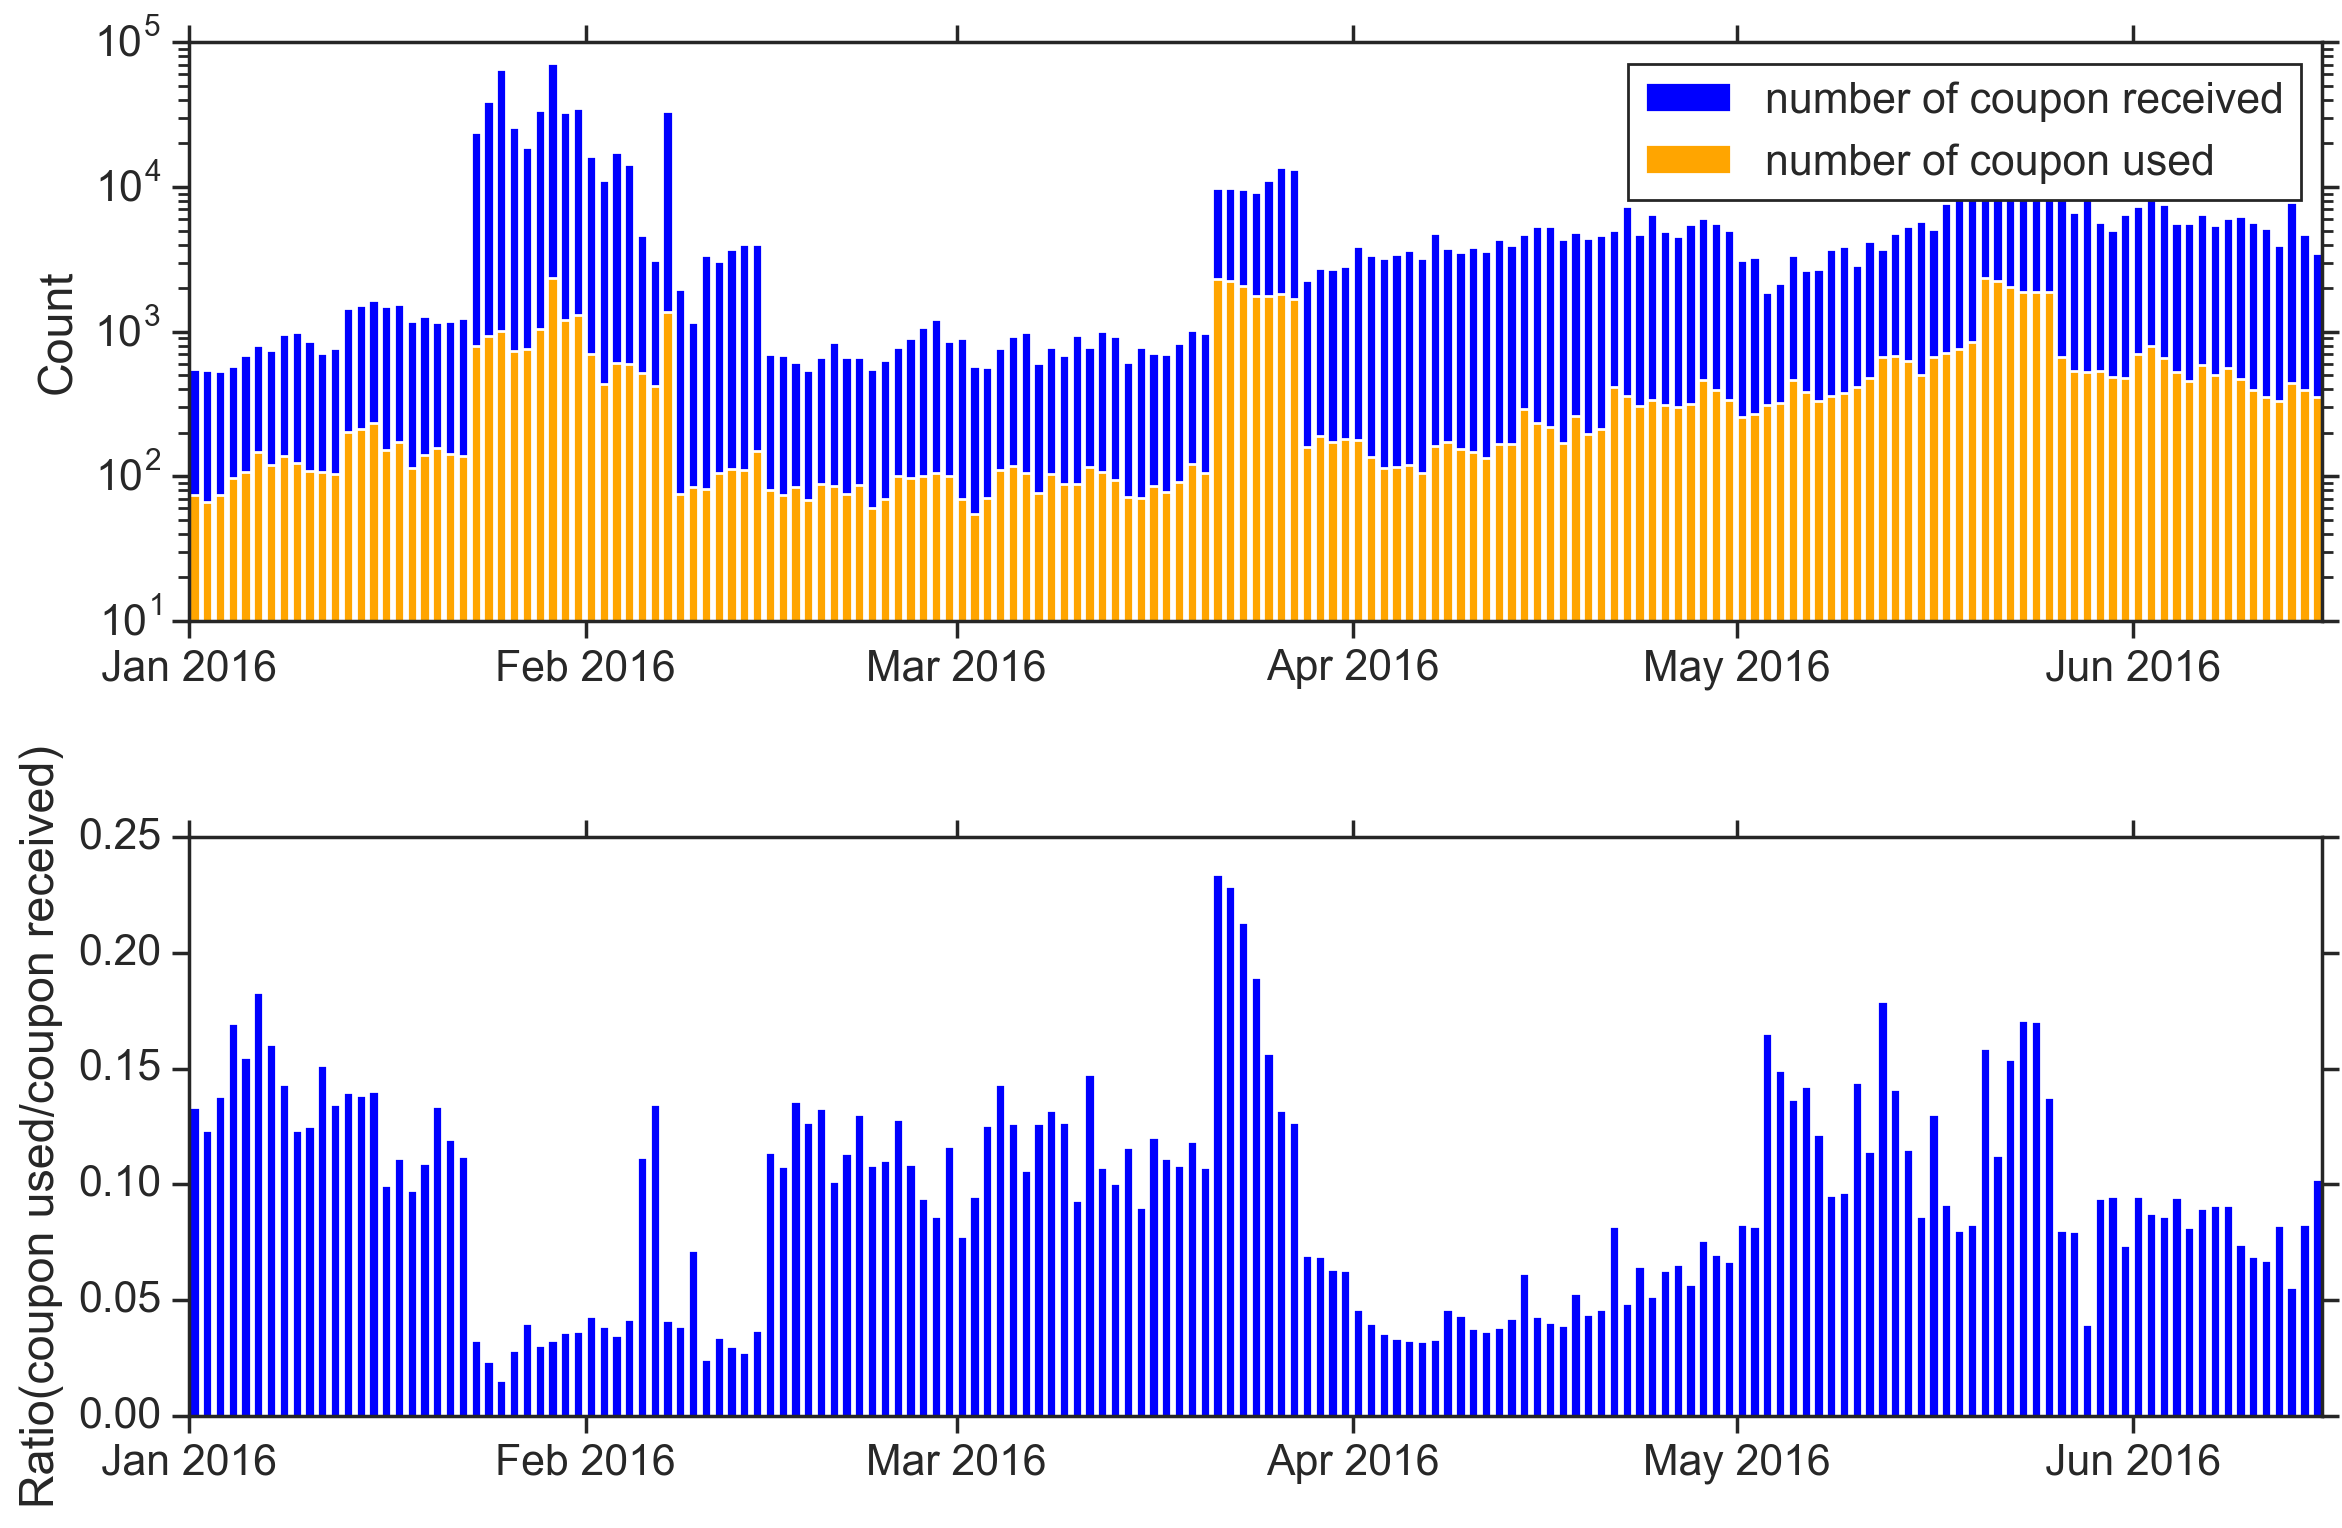

In [110]:
sns.set_style('ticks')

sns.set_context("notebook", font_scale= 1.4)

plt.figure(figsize = (12,8))

date_received_dt = pd.to_datetime(date_received, format='%Y%m%d')

 

plt.subplot(211)

plt.bar(date_received_dt, couponbydate['count'], label = 'number of coupon received' )

plt.bar(date_received_dt, buybydate['count'], label = 'number of coupon used',color='orange')

plt.yscale('log')

plt.ylabel('Count')

plt.legend()

 

plt.subplot(212)

plt.bar(date_received_dt, buybydate['count']/couponbydate['count'])

plt.ylabel('Ratio(coupon used/coupon received)')

plt.tight_layout()

新建关于星期的特征
1.wekkday:{1,2,3,4,5,6,7}
2.weekday_1,...,weekday_7:{0,1}

In [115]:
def getWeekday(row):
    if row == 'null':
        return row
    else:
        return date(int(row[0:4]),int(row[4:6]),int(row[6:8])).weekday()+1

dfoff['weekday'] = dfoff['Date_received'].astype(str).apply(getWeekday)
dftest['weekday'] = dftest['Date_received'].astype(str).apply(getWeekday)

#weekday_type:周六和周日为1,其他为0
dfoff['weekday_type']= dfoff['weekday'].apply(lambda x:1 if x in [6.7] else 0)
dftest['weekday_type']=dftest['weekday'].apply(lambda x: 1 if x in [6,7] else 0)

In [125]:
# change weekday to one-hot encoding 

weekdaycols = ['weekday_' + str(i) for i in range(1,8)]

print(weekdaycols)

tmpdf = pd.get_dummies(dfoff['weekday'].replace('null', np.nan))

tmpdf.columns = weekdaycols

dfoff[weekdaycols] = tmpdf

tmpdf = pd.get_dummies(dftest['weekday'].replace('null', np.nan))

tmpdf.columns = weekdaycols

dftest[weekdaycols] = tmpdf

['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


# 数据标注

三类：
Date_received == 'null':y=-1
Date !='null'&Date-Date_received<=15:y=1
Otherwise:y = 0

In [136]:
def label(row):

    if row['Date_received'] == 'null':

        return -1

    if row['Date'] != 'null':

        td = pd.to_datetime(row['Date'], format='%Y%m%d') -  pd.to_datetime(row['Date_received'], format='%Y%m%d')

        if td <= pd.Timedelta(15, 'D'):

            return 1

    return 0

dfoff['label'] = dfoff.apply(label, axis = 1)

In [137]:
dfoff['label'].value_counts()

 0    988887
-1    701602
 1     64395
Name: label, dtype: int64

In [138]:
print('已有columns：',dfoff.columns.tolist())

已有columns： ['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance', 'Date_received', 'Date', 'discount_rate', 'discount_man', 'discount_jian', 'distance', 'discount_type', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'label']


In [139]:
dfoff.head(2)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,discount_rate,discount_man,discount_jian,...,weekday,weekday_type,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,label
0,1439408,2632,null,null,0,null,20160217,1.000000,0,0,...,null,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
1,1439408,4663,11002,150:20,1,20160528,null,0.866667,150,20,...,6,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


# 最naive的模型

直接用discount,distance,weekday类的特征
train/valid的划分：用20160101到20160515的作为train,20160516到20160615作为calid.
用线性模型SGDclassifer


In [141]:
#data split
df = dfoff[dfoff['label']!=-1].copy()
train = df[(df['Date_received']<'20160516')].copy()
valid = df[(df['Date_received']>='20160516')&(df['Date_received']<='20160615')].copy()
print(train['label'].value_counts())
print(valid['label'].value_counts())

0    759172
1     41524
Name: label, dtype: int64
0    229715
1     22871
Name: label, dtype: int64


In [142]:
#feature
original_feature = original_feature = ['discount_rate','discount_type','discount_man', 'discount_jian','distance', 'weekday', 'weekday_type'] + weekdaycols
print(len(original_feature),original_feature)

14 ['discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'distance', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


In [ ]:
#model
predictors = original_feature
print(predictors)

def check_model(data,predictors):
    classifier = lambda:SGDClassifier(
    loss = 'log',
    penalty = 'elastincnet',
    fix_intercept = True,
    max_iter = 100.
    shuffle = True,
    n_jobs = 1,
    class_weight = None)
    
    model = Pipeline(steps = [
            ('ss',StandardScaler()),
            ('en',classifier())
        ])
    parameters = {

        'en__alpha': [ 0.001, 0.01, 0.1],

        'en__l1_ratio': [ 0.001, 0.01, 0.1]

    }
    
    